In [ ]:
!pip install wandb
!pip install transformers

In [ ]:
import os
import pdb
import pandas as pd
import wandb
import argparse
import nltk
from collections import Counter
from dataclasses import dataclass, field
from typing import Optional
from collections import defaultdict

import torch
from torch.nn.utils.rnn import pad_sequence


import re
import numpy as np
from tqdm import tqdm, trange

from transformers import (
    BertForSequenceClassification,
    BertTokenizer,
    AutoConfig,
    AdamW
)

In [ ]:
# \n 포함되어 처리 됨, 공백 제거, 마침표 제거, Task 필요하지 않음
def make_id_file(swords = False):
    if swords == True:
      from nltk.corpus import stopwords
      nltk.download('stopwords')
    def make_data_strings(file_name, swords = swords):
        data_strings = []
        pattern = '[\r|\n]'
        with open(os.path.join('./goorm', file_name), 'r', encoding='utf-8') as f:
            id_file_data = [line.lower() for line in f.readlines()]
        for item in id_file_data:
            texts = ''.join([str(k) for k in item])
            # Remove punctuation
            texts = re.sub(r'_num_', " ", texts)
            texts = re.sub("[\.\,\!\?\:\;\-\=\/\|\'\(\']", " ", texts)
            texts = re.sub(pattern=pattern, repl='', string=texts).rstrip().split()

            if swords == True:
              stop = stopwords.words('english')
              texts = [text for text in texts if text not in stop]
            data_strings.append(' '.join(texts))
        return data_strings
    
    print('it will take some times...')
    train_pos = make_data_strings('sentiment.train.1', swords)
    train_neg = make_data_strings('sentiment.train.0', swords)
    dev_pos = make_data_strings('sentiment.dev.1', swords)
    dev_neg = make_data_strings('sentiment.dev.0', swords)

    print('make id file finished!')
    return train_pos, train_neg, dev_pos, dev_neg

In [ ]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [ ]:
train_pos, train_neg, dev_pos, dev_neg = make_id_file(swords = True)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
it will take some times...
make id file finished!


In [ ]:
train_pos[:10]

['excellent food',
 'superb customer service',
 'also daily specials ice cream really good',
 'good toasted hoagie',
 'staff friendly',
 'good bar food',
 'good service',
 'soup day homemade lots specials',
 'great place lunch bar snacks beer',
 'new range looks amazing']

In [ ]:
df_train_pos = pd.DataFrame({'data': train_pos, 'label': 1})
df_train_neg = pd.DataFrame({'data': train_neg, 'label': 0})
df_train = pd.concat([df_train_pos,df_train_neg])
df_train['length'] = df_train['data'].apply(len)

df_test_pos = pd.DataFrame({'data': dev_pos, 'label': 1})
df_test_neg = pd.DataFrame({'data': dev_neg, 'label': 0})
df_test = pd.concat([df_test_pos,df_test_neg])
df_test['length'] = df_test['data'].apply(len)
df = pd.concat([df_train,df_test])

In [ ]:
df

,data,label,length
0,excellent food,1,14
1,superb customer service,1,23
2,also daily specials ice cream really good,1,41
3,good toasted hoagie,1,19
4,staff friendly,1,14
...,...,...,...
1995,sad see much place gone downhill,0,32
1996,food n good,0,11
1997,n quite years,0,13
1998,service last time went terrible,0,31


전체 데이터셋의 크기: 447259

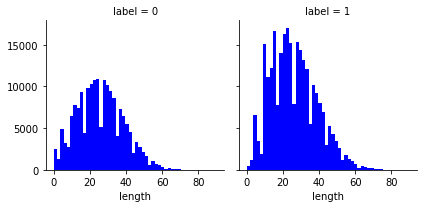

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
graph = sns.FacetGrid(data=df,col='label')
graph.map(plt.hist,'length',bins=50,color='blue')

In [ ]:
#Null 데이터 확인
df.isnull().sum()

data      0
label     0
length    0
dtype: int64

In [ ]:
#아무것도 포함되지 않은 행렬 확인, 제거
print(df.loc[df['length'] <= 1])
none_idx = df.loc[df['length'] <= 1].index
df = df.drop(none_idx)

     data  label  length
614     )      1       1
1301           1       0
1759    )      1       1
1942    )      1       1
2233    )      1       1
...   ...    ...     ...
1893           0       0
1894           0       0
1896           0       0
1897           0       0
1898           0       0

[2885 rows x 3 columns]


In [ ]:
print(df.loc[df['length'] <= 1])

Empty DataFrame
Columns: [data, label, length]
Index: []


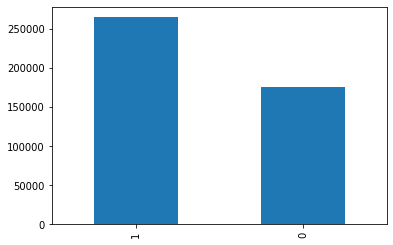

In [ ]:
# 긍부정 리뷰 갯수 파악
df['label'].value_counts().plot(kind = 'bar')

In [ ]:
print(df.groupby('label').size().reset_index(name = 'count'))

   label   count
0      0  176398
1      1  265080


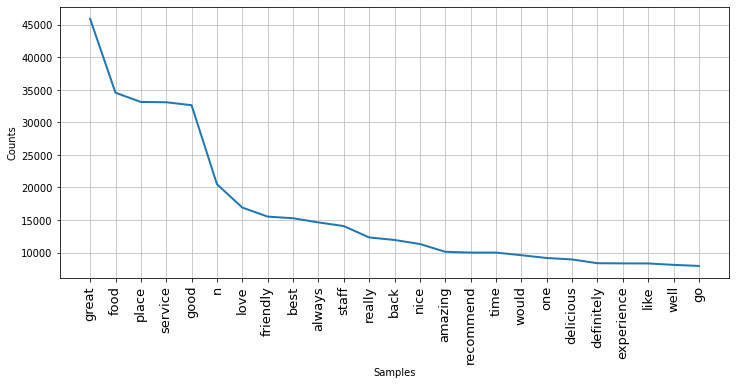

In [ ]:
# most common words in twitter dataset 
all_texts = []
for line in list(df['data']):
    texts = line.split()
    for text in texts:
        all_texts.append(text)
# plot word frequency distribution of first few words
plt.figure(figsize=(12,5))
plt.xticks(fontsize=13, rotation=90)
fd = nltk.FreqDist(all_texts)
fd.plot(25,cumulative=False)
# log-log of all words 
word_counts = sorted(Counter(all_texts).values(), reverse=True)